In [1]:
import pandas as pd
import re
import pyarrow

>* We are going to use email data from program-l mailing list to build edges and nodes for the graph.
>* https://www.freelists.org/archive/program-l
> * Let's read file using `pd.read_feather` 

>* feather file is a fast, lightweight, and easy-to-use binary file format for storing data frames. 
>* Downloading pre-requisite libraries may necessary to read feather file. 

In [2]:
data=pd.read_feather('sample-feather.feather')

> * Let's check the columns

In [3]:
data.columns

Index(['thread_id', 'thread_name', 'body', 'account', 'url', 'date',
       'longevity'],
      dtype='object')

>* Let's check datatypes

In [4]:
data.dtypes

thread_id                int64
thread_name             object
body                    object
account                 object
url                     object
date                    object
longevity      timedelta64[ns]
dtype: object

>* Let's check the first few rows of the dataframe

In [5]:
data.head()

,thread_id,thread_name,body,account,url,date,longevity
0,5608,Tool-to-log-all-messages-targeting-a-given-window,"[Hello all, Does someone here know of a tool t...","[webmaster, jtwauthier, soronel.haetir]",[https://www.freelists.org/post/program-l/Tool...,"[2016-01-19T10:12:01.000000000, 2016-01-19T15:...",0 days 06:12:00
1,6826,html5js-newby,"[HI All, I'm trying to create a demo for aira ...","[blindwiz, taksantong, blindwiz]",[https://www.freelists.org/post/program-l/html...,"[2019-02-20T07:34:07.000000000, 2019-02-20T17:...",0 days 13:54:20
2,4209,Searching-in-dataTables-vbnet,[Hi all. A dataTable is the registers of one t...,"[pmorales, ofbgmail, pmorales, ofbgmail, pmora...",[https://www.freelists.org/post/program-l/Sear...,"[2013-09-02T23:01:35.000000000, 2013-09-03T15:...",5 days 17:13:11
3,2119,Ot-looking-for-an-app,"[Hello, I've got an assignment for management ...","[compgeek13, justind, wunderg]",[https://www.freelists.org/post/program-l/Ot-l...,"[2008-11-11T00:52:32.000000000, 2008-11-11T13:...",0 days 14:42:00
4,2906,Learn-Python-The-Hard-Way-Second-Edition,"[Hi, For those interested, Learn Python Hard W...","[james.homme, jr]",[https://www.freelists.org/post/program-l/Lear...,"[2011-12-05T12:45:48.000000000, 2011-12-05T16:...",0 days 04:05:30


>* In `data` dataframe, we have six columns, each representing as follows:
    
    * `thread_id` : unique id for each thread
    * `thread_name` : the first subject of the email
    * `body` : the content of the email 
    * `account` : the email account of the sender 
    * `url` : the url of the email
    * `date` : the date of the email 

> * Think of thread as an email conversation. `thread_id` is the unique id for the email conversation.

>* Let's check which thread has the most number of accounts involved in the conversation.

In [6]:
data['account'].apply(lambda x: len(x)).sort_values(ascending=False)

39    43
63    32
81    15
73    14
33    13
      ..
57     2
58     2
59     2
66     2
85     2
Name: account, Length: 100, dtype: int64

> * The index of 39 has 43 users involved in the conversation.
> * Let's see who are the users involved in the conversation.

In [7]:
data.loc[39, 'account']

array(['water.swift', 'rawoolgrove', 'water.swift', 'rawoolgrove',
       'shooley2', 'lucasradaelli', 'michael.e.walker3', 'tspivey',
       'water.swift', 'michael.e.walker3', 'jamyad7', 'michael.e.walker3',
       'jamyad7', 'michael.e.walker3', 'james', 'michael.e.walker3',
       'james', 'michael.e.walker3', 'florianbeijers', 'daremc86',
       'florianbeijers', 'jacobk', 'jacobk', 'trouble1', 'james',
       'michael.e.walker3', 'water.swift', 'water.swift',
       'michael.e.walker3', 'michael.e.walker3', 'water.swift',
       'michael.e.walker3', 'water.swift', 'michael.e.walker3',
       'water.swift', 'michael.e.walker3', 'jacobk', 'dleavens', 'james',
       'michael.e.walker3', 'jamyad7', 'compgeek13', 'cmusic789'],
      dtype=object)

>* We can see some of the users are repeating, meaning they are involved in the conversation multiple times.

>* We want to see the unique users involved in the conversation.
>* To do so, we want to use `nunique()` function to get the number of unique elements in `pd.Series` object.
> * So, we have to convert the list into `pd.Series` object.

In [8]:
data['account'].apply(lambda x: pd.Series(x).nunique()).sort_values(ascending=False)

39    15
63    14
33    10
6      7
73     7
      ..
30     2
29     2
24     2
99     2
47     1
Name: account, Length: 100, dtype: int64

> * We can still find the index 39 has the most unique users involved in the conversation.
> * But the third most unique users involved in the conversation is different from the most users involved in the conversation.

> * Let's do text mining on the `body` column to find the most common words used in the conversation.
> * To do so, let's import necessary libraries we practiced in the previous classes.

In [9]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

>* We learned the importance of pre-processing before doing text mining.
> * Lowercasing, removing punctuation, removing stop words, and tokenization are the most common pre-processing steps.

>* The body column is a list. We have to join the strings in the list to make it a single string.

In [10]:
data['body'].apply(lambda x: len(x))

0      3
1      3
2     11
3      3
4      2
      ..
95     4
96     6
97     3
98     7
99     3
Name: body, Length: 100, dtype: int64

In [11]:
data['body-str'] = data['body'].apply(lambda x: ' '.join(x))

>* Let's lowercase the body column first.

In [12]:
data['body-lower']=data['body-str'].apply(lambda x: x.lower())

In [13]:
print(data['body-str'].iloc[0]) #before lowercasing

Hello all, Does someone here know of a tool that could hook to the message loop of an application is able to filter log all messages having a given destination window? In fact, I'm developing a win32 app I would like to know what happens / what messages / notifications are sent when the user press a routine cursor on his braille display to move the cursor a multiline text area. I don't have a braille display myself thus am unable to test alone. Thank you for your answers! If I understand your intent correctly, there are a lot of event intercept logging facilities. Which tools are available depends on the language technologies that power your application. It might be helpful to start by looking the Win32 API docs to see what logging event functions are available. Then you can see if the language or technologies implement those functions. It sounds like you want to hook into the key press events consolidate all of those events into a logger that outputs to a specified dialog or file that

In [14]:
print(data['body-lower'].iloc[0])

hello all, does someone here know of a tool that could hook to the message loop of an application is able to filter log all messages having a given destination window? in fact, i'm developing a win32 app i would like to know what happens / what messages / notifications are sent when the user press a routine cursor on his braille display to move the cursor a multiline text area. i don't have a braille display myself thus am unable to test alone. thank you for your answers! if i understand your intent correctly, there are a lot of event intercept logging facilities. which tools are available depends on the language technologies that power your application. it might be helpful to start by looking the win32 api docs to see what logging event functions are available. then you can see if the language or technologies implement those functions. it sounds like you want to hook into the key press events consolidate all of those events into a logger that outputs to a specified dialog or file that

>* Okay! lowercasing is done. Now, let's remove the stopwords

In [15]:
stop=stopwords.words('english')
#loading stopwords in the variable named stop

In [16]:
data['stopword']=data['body-lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
#The lambda function takes each row of the 'body-lower' column, splits it into a list of words, 
#and then joins the words back together into a string, excluding any words that are in the 'stop' list.

In [17]:
data['body-lower'].iloc[98]

"hi: further to my post yesterday: eclipse has a very good set of example files for the editing or validation of xml files. 1. create a workspace. 2. set your perspective to java. 3. create a new examples project by first opening file / / other menu option. 4. select examples from the list, it should be the last of 22 items. 5. select the xml option. 6. select the editing validation option. a tutorial should appear a new project will be created. i believe five different xml projects are part of the project, each have a step by step tutorial on how to interact with them. 7. programmer / analyst wcag 2. 0 aa assessor / jaws sme enterprise solutions directorate ( besd ). registration, infrastructure support portals ( brisp ) revenue agency | agence du revenu du: h4 - 202 875 road, on k1a 0l5 , keep them coming! this fantastic information is invaluable! i really appreciate your help. i would never have been able to get started the way things were when i first installed eclipse. now i can g

In [18]:
data['stopword'].iloc[98]

"hi: post yesterday: eclipse good set example files editing validation xml files. 1. create workspace. 2. set perspective java. 3. create new examples project first opening file / / menu option. 4. select examples list, last 22 items. 5. select xml option. 6. select editing validation option. tutorial appear new project created. believe five different xml projects part project, step step tutorial interact them. 7. programmer / analyst wcag 2. 0 aa assessor / jaws sme enterprise solutions directorate ( besd ). registration, infrastructure support portals ( brisp ) revenue agency | agence du revenu du: h4 - 202 875 road, k1a 0l5 , keep coming! fantastic information invaluable! really appreciate help. would never able get started way things first installed eclipse. get going. beginning get confident xml i'm put tutorial practice. i'll let know get on, like? hi: yes, let list know well. learn much other's experiences. program java list? no, list? list created newby java programmers. sort t

> * This time, let's do tokenization.

In [19]:
data['token']=data['stopword'].apply(lambda x: word_tokenize(x))

In [20]:
data['token'].iloc[98][:10]

['hi',
 ':',
 'post',
 'yesterday',
 ':',
 'eclipse',
 'good',
 'set',
 'example',
 'files']

>* Finally let's get rid of the punctuation.

In [21]:
data['punct_token']=data['token'].apply(lambda x: [word for word in x if word.isalnum()])
#if the string is alphanumeric, it is included in the list

In [22]:
data['punct_token'].iloc[98][:10]

['hi',
 'post',
 'yesterday',
 'eclipse',
 'good',
 'set',
 'example',
 'files',
 'editing',
 'validation']

>* We are interested in finding the most common words used in the thread (email conversation) index 39.

In [23]:
from collections import Counter

In [24]:
Counter(data['punct_token'].iloc[30]).most_common(10)

[('liblouis', 9),
 ('lou', 8),
 ('exe', 8),
 ('0', 4),
 ('want', 3),
 ('program', 3),
 ('python', 3),
 ('6', 3),
 ('1', 3),
 ('thanks', 3)]

> * Let's see which thread has been alive for the longest time.
> * Some email lasts for a few days, some for a few months, and some for a few years.
> * We can calculate the time difference between the first and the last email of the thread.

In [25]:
data['date'].apply(lambda x: x.max())
#max() function will return the latest date 

0    2016-01-19 16:24:01
1    2019-02-20 21:28:27
2    2013-09-08 16:14:46
3    2008-11-11 15:34:32
4    2011-12-05 16:51:18
             ...        
95   2005-02-09 14:19:03
96   2012-09-21 18:13:26
97   2022-09-09 08:20:39
98   2013-11-05 21:50:38
99   2012-07-27 08:17:46
Name: date, Length: 100, dtype: datetime64[ns]

In [26]:
data['date'].apply(lambda x: x.min())
#min() function will return the earliest date

0    2016-01-19 10:12:01
1    2019-02-20 07:34:07
2    2013-09-02 23:01:35
3    2008-11-11 00:52:32
4    2011-12-05 12:45:48
             ...        
95   2005-02-07 23:54:06
96   2012-09-20 08:28:50
97   2022-09-08 22:35:03
98   2013-11-05 18:59:23
99   2012-07-26 08:44:50
Name: date, Length: 100, dtype: datetime64[ns]

In [27]:
data['date'].apply(lambda x: x.max()-x.min()).sort_values(ascending=False) 
#combining max() and min() function together will reutrn the difference between the latest and earliest date

6    1739 days 02:25:49
5      10 days 11:32:27
75      6 days 19:26:56
63      6 days 00:33:38
2       5 days 17:13:11
            ...        
66      0 days 00:40:59
85      0 days 00:28:10
47      0 days 00:23:22
58      0 days 00:10:56
84      0 days 00:05:09
Name: date, Length: 100, dtype: timedelta64[ns]

> * Okay, the thread with index 6 has been conversing more than 1000 days!

>* Let's see what users have been talking about in the thread with index 6.

In [28]:
data.loc[6, 'body']

array(['Hello, I tried installing the PyCharm IDE, to my dismay, nothing spoke after the installation. Is there an extra step that I have to go through order to get the program to work with NVDA, or is use of PyCharm not available this time, as it is with the InteliJ IDE? Thanks,',
       'extra step is to change the IDE. PyCharm is InteliJ based.',
       "Gave it a quick test, while you can make some things start happening using on - screen - OCR, using NVDA 2015. 4, definitely doesn't seem like it will really have much to offer that sense..?",
       'all, I am currently taking an introductory science course college. instructors recommend PyCharm as the coding environment, but I was wondering if it is accessible with NVDA. Even if with some tweaks, I would prefer to use PyCharm along with my sighted peers if possible. If not, please suggest alternative accessible IDEs. I would truly appreciate any assistance. Thanks. - -',
       '>>',
       'Hi, PyCharm is not fully accessible. So

In [29]:
data.loc[6, 'date']
#The earlist date of this conversation is 2015-12-22 and the latest date is 2020-09-25

array(['2015-12-22T10:17:47.000000000', '2015-12-22T10:21:16.000000000',
       '2015-12-22T10:37:10.000000000', '2020-09-20T16:59:13.000000000',
       '2020-09-20T17:42:55.000000000', '2020-09-20T17:44:12.000000000',
       '2020-09-20T20:30:17.000000000', '2020-09-21T08:29:08.000000000',
       '2020-09-25T12:43:36.000000000'], dtype='datetime64[ns]')

>* Let's see the most common words used in the thread that has been alive for the longest time.

In [30]:
Counter(data['punct_token'].iloc[6]).most_common(10)

[('pycharm', 8),
 ('accessible', 8),
 ('ide', 5),
 ('step', 4),
 ('thanks', 4),
 ('probably', 4),
 ('nvda', 3),
 ('make', 3),
 ('using', 3),
 ('much', 3)]

>* Let's jump into the network part of this data.
>* Always remember there are three main components of a network: nodes, edges, and attributes.

In [31]:
import networkx as nx

>* How do you want to design the graph with the given data?

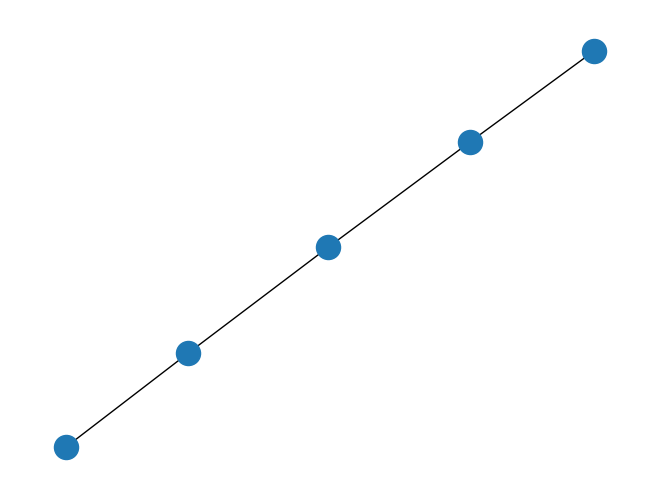

In [32]:
G=nx.path_graph(5)
nx.draw(G)

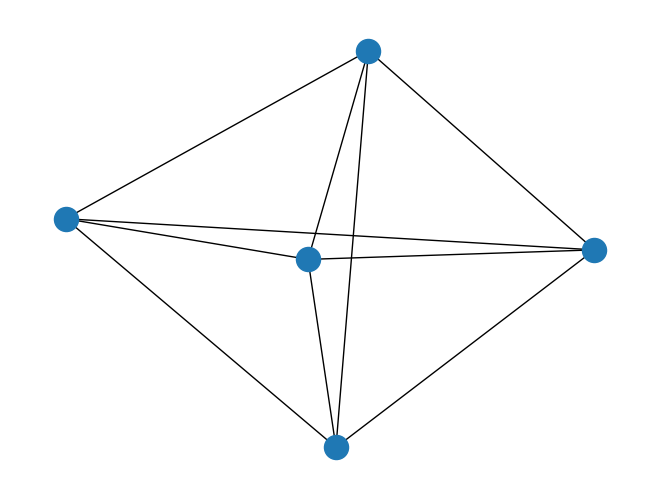

In [33]:
C=nx.complete_graph(5)
nx.draw(C)

> * If we think about directionality, the path graph will look like below

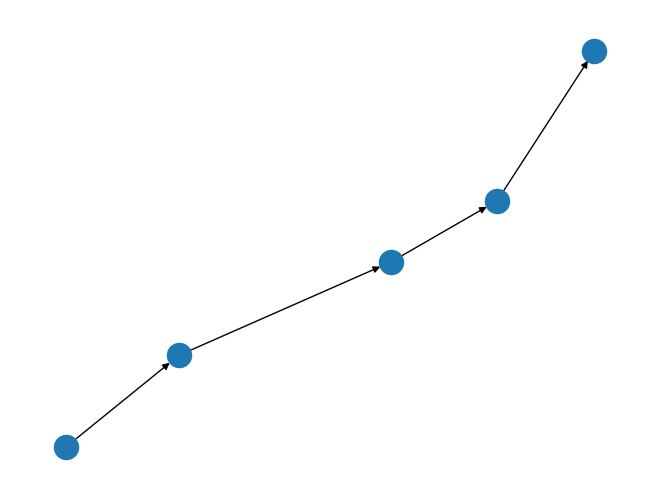

In [34]:
G=nx.path_graph(5, create_using=nx.DiGraph())
nx.draw(G)

>* But given the nature of back-and-forth conversation in the email, there is high likelihood that the graph will be undirected.

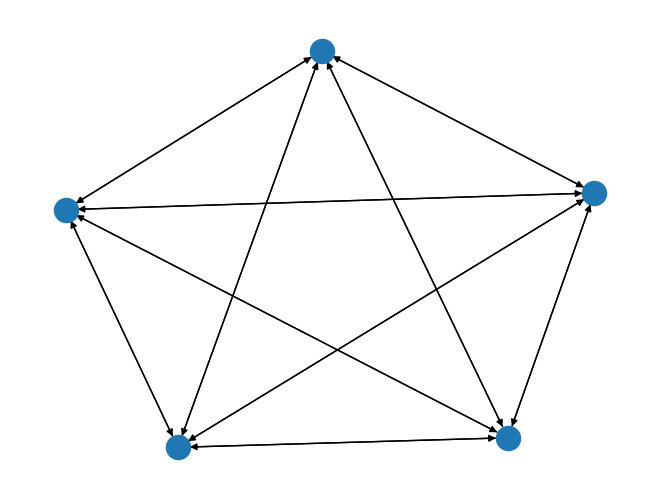

In [35]:
C_directed=nx.complete_graph(5, create_using=nx.DiGraph())
nx.draw(C_directed)

> * Let's think about nodes
> * Where can we get the nodes from? It is in the `account` column but data is in the list object.

In [36]:
data['account']

0               [webmaster, jtwauthier, soronel.haetir]
1                      [blindwiz, taksantong, blindwiz]
2     [pmorales, ofbgmail, pmorales, ofbgmail, pmora...
3                        [compgeek13, justind, wunderg]
4                                     [james.homme, jr]
                            ...                        
95    [tim.burgess, will-pearson, will-pearson, tim....
96    [tuannamduong, george, tuannamduong, george, t...
97                       [joeldodson, parham90, iz4apu]
98    [james.corbett, cearbhall.omeadhra, james.corb...
99                [clau9274, joseph.lee22590, clau9274]
Name: account, Length: 100, dtype: object

>* How many unique nodes are there in the data?

In [37]:
pd.Series([item for sublist in data['account'] for item in sublist]).nunique()

140

> * Let's build edges between users in the conversation (thread).
> * To do so, we will use the `account` column and iterate over the rows to created edges between users.

In [38]:
#We will need a combination of all the accounts in the 'account' column to create the edges of the graph
#We will use itertools.combinations to create the combination

import itertools
edges=[]
for idx, val in data['account'].items():
    edges.extend(list(itertools.combinations(val, 2)))

In [39]:
edges[:10]

[('webmaster', 'jtwauthier'),
 ('webmaster', 'soronel.haetir'),
 ('jtwauthier', 'soronel.haetir'),
 ('blindwiz', 'taksantong'),
 ('blindwiz', 'blindwiz'),
 ('taksantong', 'blindwiz'),
 ('pmorales', 'ofbgmail'),
 ('pmorales', 'pmorales'),
 ('pmorales', 'ofbgmail'),
 ('pmorales', 'pmorales')]

>* Let's get rid of the self-loops.

In [40]:
edges_loop = [edge for edge in edges if edge[0] != edge[1]]

In [41]:
edges_loop[:10]

[('webmaster', 'jtwauthier'),
 ('webmaster', 'soronel.haetir'),
 ('jtwauthier', 'soronel.haetir'),
 ('blindwiz', 'taksantong'),
 ('taksantong', 'blindwiz'),
 ('pmorales', 'ofbgmail'),
 ('pmorales', 'ofbgmail'),
 ('pmorales', 'ofbgmail'),
 ('pmorales', 'sonfire11'),
 ('pmorales', 'ofbgmail')]

>* We can also get rid of the duplicate edges if we want to design the graph as an unwieghted graph.

In [42]:
edges_loop = list(set(edges_loop))

In [43]:
edges_loop[:10]

[('spg1111', 'compgeek13'),
 ('james', 'florianbeijers'),
 ('ofbgmail', 'sonfire11'),
 ('soronel.haetir', 'essence64'),
 ('travis', 'lauraeaves'),
 ('compgeek13', 'dkreynolds'),
 ('webmaster', 'lras'),
 ('justind', 'jamal.mazrui'),
 ('jhomme', 'lras'),
 ('florianbeijers', 'stefika')]

>* Let's see who has the highest degree centrality in the graph.

In [44]:
degree={}
for element in pd.Series([item for sublist in data['account'] for item in sublist]).unique():
    count=0
    for edge in edges_loop:
        if element in edge:
            count+=1
    degree[element]=count    

> * To sort degree based on the value of the degree, we can use `sorted` function.

In [45]:
sorted_x = sorted(degree.items(), key=lambda k: k[1], reverse=True)
sorted_dict = dict(sorted_x)
dict(list(sorted_dict.items())[:10])

{'jacobk': 65,
 'compgeek13': 57,
 'florianbeijers': 53,
 'travis': 46,
 'dzhovani.chemishanov': 43,
 'soronel.haetir': 40,
 'jamyad7': 40,
 'jhomme': 39,
 'webmaster': 38,
 'rawoolgrove': 37}

In [46]:
degree_centrality={}
for key, value in sorted_dict.items():
    degree_centrality[key]=value/(len(pd.Series([item for sublist in data['account'] for item in sublist]).unique())-1)

>* `jacobk` has the highest degree centrality in the graph.
>* Let's compare `jacobk` degree centrality

In [47]:
degree_centrality['jacobk']

0.4676258992805755

>* Practice

>* This time, we want to subset the data to only include the conversation that has involved `jacobk`.
>* Hint! `isin` function can be useful. Remember `isin()` function is from `pd.Series` object.
>* Also, try `.apply()` and `lambda` function.

>* Let's put the result in `jacobkdf` variable.

In [61]:
#YOUR CODE HERE
jacobkdf = data['punct_token'].apply(lambda x: x.isin("jacobk"))

AttributeError: 'list' object has no attribute 'isin'

>* We are curious about the most common words that `jacobk` has used in the conversation.
>* We have to use `body` column because in `punct-token` we already joined all the strings in the `body` column.
>* The strings in `body` column follow the order in the `account` column, meaning the first string in `body` column has been sent by the first user in the `account` column. 

>* Let's find the index (order) of `jacobk` in the `account` column in the `jacobkdf` dataframe.

In [49]:
#YOUR CODE HERE

>* Let's print what `jacobk` sent in the conversation.
>* You can use the index (order) found in the previous step.

In [50]:
#YOUR CODE HERE

>* Okay, `jacobk` has sent 31 emails in 13 different threads.

>* Let's do text mining:
>* (1) Lowercasing
>* (2) Tokenization
>* (3) Removing stopwords
>* (4) Removing punctuation

>* (1) Lowercasing

In [51]:
#YOUR CODE HERE

> * (2) Tokenization

In [52]:
#YOUR CODE HERE

>* (3) Removing stopwords

In [53]:
#YOUR CODE HERE

> * (4) Removing punctuation

In [54]:
#YOUR CODE HERE

>* If we did all the pre-processing steps correctly, we can find the most common words used by `jacobk` in the conversation.
>* Q. What are the most 10 common words used by `jacobk`?

In [55]:
#YOUR CODE HERE

>* Let's build edges from the `jacobkdf` dataframe.
>* To do so, let's iterate over the rows

In [56]:
#YOUR CODE HERE

>* Let's get rid of the self-loops.

In [57]:
#YOUR CODE HERE

>* Let's get rid of the duplicate edges.

In [58]:
#YOUR CODE HERE

>* How many edges are there in the final graph?

In [59]:
#YOUR CODE HERE